In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

# Lonzo Ball Shooting Exploratory Data Analysis

As a personal project I explore Lonzo Ball's shooting this season using data publicly available on basketballreference.com. 

Data collected on: **March 10th, 2018**. 

<img src="http://a.espncdn.com/combiner/i?img=/i/headshots/nba/players/full/4066421.png&w=350&h=254", width=300,height= 300 >

## I. Scraping Shot Data from BasketballReference.com

### Parsing the page with BeautifulSoup

In [5]:
import requests
resp = requests.get(
    "https://www.basketball-reference.com/players/b/balllo01/shooting/2018")
resp

<Response [200]>

In [6]:
from bs4 import BeautifulSoup, Comment
content = BeautifulSoup(resp.content, 'html.parser')
print(content.prettify()[0:500])

<!DOCTYPE html>
<html class="no-js" data-root="/home/bbr/www" data-version="klecko-" itemscope="" itemtype="https://schema.org/WebSite" lang="en">
 <head>
  <meta charset="utf-8"/>
  <meta content="ie=edge" http-equiv="x-ua-compatible"/>
  <meta content="width=device-width, initial-scale=1.0, maximum-scale=2.0" name="viewport">
   <link href="https://d2p3bygnnzw9w3.cloudfront.net/req/201801291" rel="dns-prefetch"/>
   <!-- no:cookie fast load the css.           -->
   <link crossorigin="" href="


After examining the source html we see that the shot data is contained within a comment. Therefore we find all the comments in the document and then pick out the one with the shot data. 

In [7]:
comments = content.find_all(text=lambda text:isinstance(text, Comment))
comments[:5]

[' no:cookie fast load the css.           ',
 ' tiles, touch, favicons ',
 '[if IE]>\n    <link rel="shortcut icon"                                href="https://d2p3bygnnzw9w3.cloudfront.net/req/201801291/favicons/bbr/favicon.ico"><![endif]',
 ' <li><a href="https://widgets.sports-reference.com/">Widgets</a></li>',
 ' ul.user ']

In [8]:
shots_html = comments[21]
shots_html[:1000]

'\n   <div class="table_outer_container">\n      <div class="overthrow table_container" id="div_shot-chart">\n  <table class="suppress_all sortable stats_table" id="shot-chart" data-cols-to-freeze=2><caption>Shot Chart Table</caption><div id="shot-wrapper">\n<div class="shot-area">\n<img src="http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png" \n     alt="nbahalfcourt" \n     >\n<div style="top:145px;left:242px;" tip="Oct 19, 2017, LAL vs LAC<br>1st Qtr, 7:55 remaining<br>Missed 2-pointer from 9 ft<br>LAL trails 4-8" class="tooltip miss">&#215;</div>\n<div style="top:238px;left:72px;" tip="Oct 19, 2017, LAL vs LAC<br>1st Qtr, 4:27 remaining<br>Missed 3-pointer from 25 ft<br>LAL trails 11-15" class="tooltip miss">&#215;</div>\n<div style="top:58px;left:238px;" tip="Oct 19, 2017, LAL vs LAC<br>1st Qtr, 2:06 remaining<br>Missed 2-pointer from 0 ft<br>LAL trails 17-18" class="tooltip miss">&#215;</div>\n<div style="top:240px;left:53px;" tip="Oct 19, 2017, LAL vs LAC<br>

### Extracting fields from text using regex

In [9]:
shots_string = str(shots_html)

The first field I'll try to extract is the **shot location**, stored in the form: "top:###px;left:###px"

In [10]:
import re

shot_loc_text = re.findall('top:\d+px;left:\d+px', shots_string)
shot_loc_text[:5]

['top:145px;left:242px',
 'top:238px;left:72px',
 'top:58px;left:238px',
 'top:240px;left:53px',
 'top:65px;left:244px']

In [11]:
shot_loc = []
for i in range(len(shot_loc_text)):
    shot = shot_loc_text[i]
    nums = re.findall('\d+', shot)
    shot_loc.append([nums[0],nums[1]])
shot_loc[:5]

[['145', '242'], ['238', '72'], ['58', '238'], ['240', '53'], ['65', '244']]

We can check that we are actually getting all of Ingram's shots by verifying that the length of shot_loc is actually equal to all of Lonzo's field goal attempts, 453 according to BBallReference.

In [12]:
len(shot_loc)

451

It looks like we are missing data for two shots. Some possible explanations for this are:
1. The chart on the site is missing these shots (if it was a heave from beyond half court for example)
2. There is an error in how the site computed his total FGA
3. The data for these shots was weirdly formatted and not picked up by our regular expression 

Since we're only missing two shots I think it's fine to continue. This might be a problem though if the other fields we extract have a different number of entries, so we'll make sure all other fields have the same number of entries before creating the dataframe.


We'll now try to extract some other fields, specifically the **result** (made or missed), the **opponent**, and the **game date**. 

Note: there are other fields available including the shot distance, the gametime the shot was taken at, the game score at that time, etc.

In [13]:
shot_res = re.findall('remaining<br>[^\d]+', shots_string)
shot_res = [shot_res[i][13:-1] for i in range(len(shot_res))]
shot_res[:5]

['Missed', 'Missed', 'Missed', 'Made', 'Missed']

In [14]:
shot_opp = re.findall('LAL [av][ts] \w+', shots_string)
shot_opp = [shot_opp[i][7:] for i in range(len(shot_opp))]
shot_opp[:5]

['LAC', 'LAC', 'LAC', 'LAC', 'LAC']

In [15]:
shot_date = re.findall('tip=".+, L', shots_string)
shot_date = [shot_date[i][5:len(shot_date[i])-3] for i in range(len(shot_date))]
shot_date[:5]

['Oct 19, 2017',
 'Oct 19, 2017',
 'Oct 19, 2017',
 'Oct 19, 2017',
 'Oct 19, 2017']

We now double check that all the fields have the same length.

In [16]:
assert len(shot_loc) == len(shot_res) == len(shot_opp) == len(shot_date)

Finally, we can put the shot data into a pandas dataframe. I reconfigure some of the data (splitting location into two variables, changing result to True or False) for later convenience.

In [17]:
top_loc = [int(shot_loc[i][0]) for i in range(len(shot_loc))]
left_loc = [int(shot_loc[i][1]) for i in range(len(shot_loc))]
make = [shot_res[i] == 'Made' for i in range(len(shot_res))]

shots = pd.DataFrame(data={'top_loc':top_loc,'left_loc':left_loc, 'make': make,
                    'opp':shot_opp, 'date':shot_date},
                    columns=['date','opp','top_loc','left_loc','make'])
shots.head(5)

,date,opp,top_loc,left_loc,make
0,"Oct 19, 2017",LAC,145,242,False
1,"Oct 19, 2017",LAC,238,72,False
2,"Oct 19, 2017",LAC,58,238,False
3,"Oct 19, 2017",LAC,240,53,True
4,"Oct 19, 2017",LAC,65,244,False


## II. Plotting the shots

First I want to plot the shots to get make sure everything worked properly and get a feel for the data.

We begin by plotting all the shots, distinguishing between makes and misses, over an nba half court (image borrowed from BasketballReference). 

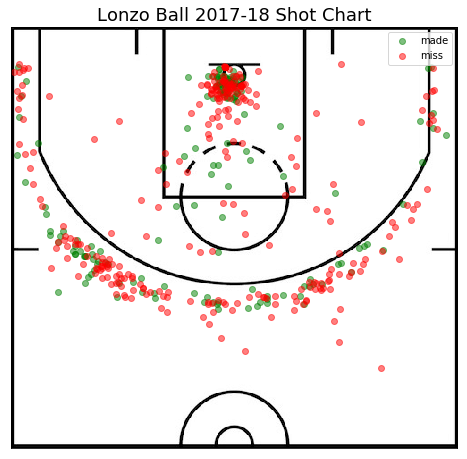

In [18]:
made = shots[shots['make']==True]
miss = shots[shots['make']==False]
court = plt.imread("nba_halfcourt.png")

fig, ax = plt.subplots(figsize=(8,8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.imshow(court)
ax.scatter(made['left_loc'], made['top_loc'],alpha=0.5,c='green',label='made')
ax.scatter(miss['left_loc'], miss['top_loc'],alpha=0.5,c='red',label='miss')
plt.title('Lonzo Ball 2017-18 Shot Chart',fontsize=18)
ax.legend()

We can also make shot charts for specific games or against specific teams. For example, let's see how Lonzo shot against Golden State this season.

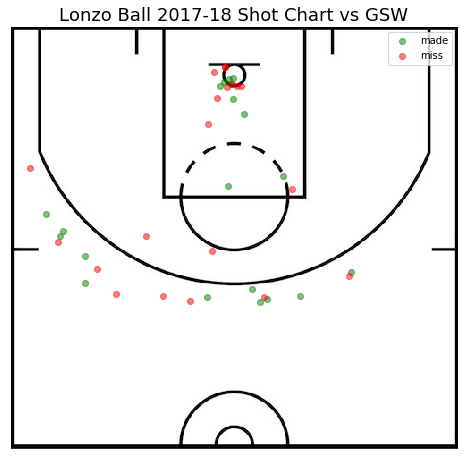

In [19]:
war_shots = shots[shots['opp']=='GSW']
war_made = war_shots[war_shots['make']==True]
war_miss = war_shots[war_shots['make']==False]


fig, ax = plt.subplots(figsize=(8,8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.imshow(court)
ax.scatter(war_made['left_loc'], war_made['top_loc'],alpha=0.5,c='green',label='made')
ax.scatter(war_miss['left_loc'], war_miss['top_loc'],alpha=0.5,c='red',label='miss')
plt.title('Lonzo Ball 2017-18 Shot Chart vs GSW',fontsize=18)

ax.legend()

In the first plot, we see Lonzo's shots are so clustered near the rim and on the wings that it makes it hard to get a sense of his shooting from these spots. I've tried to remedy this a little by making the dots partially transparent, but let's try something else.

We can bin the data into small sections of the court and compute Lonzo's averages from each bin.

In [20]:
num_makes = []
for i in range(len(shots)):
    if shots['make'][i]== True:
        num_makes.append(1)
    else:
        num_makes.append(0)
num_makes[:5]

[0, 0, 0, 1, 0]

Text(0.5,1,'Lonzo Ball 2017-18 Shot Chart')

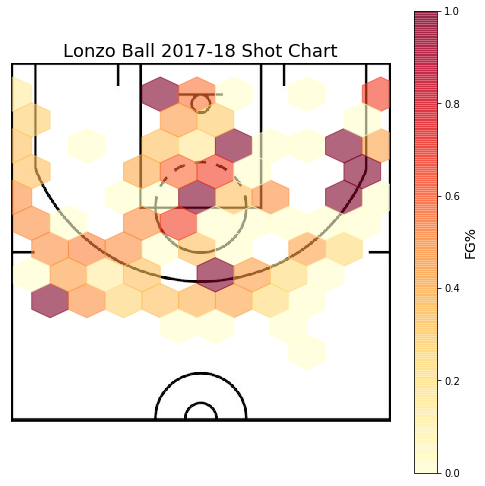

In [21]:
fig, (ax) = plt.subplots(figsize=(8.5,8.5))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

hexi = ax.hexbin(shots['left_loc'],shots['top_loc'],
                 C=num_makes,gridsize=10,cmap='YlOrRd',alpha=0.6)

ax.imshow(court)

cb = fig.colorbar(hexi, ax=ax)
cb.set_label('FG%',fontsize=14)
plt.title('Lonzo Ball 2017-18 Shot Chart',fontsize=18)

What I would have liked to have done next is to perform a similar analysis for all active players in the NBA to compute league averages from each area of the court. This would then allow me to contextualize Ingram's shooting relative to the rest of the league. For example, Lonzo's hot shooting from above the break 3's looks impressive as is, but I'm curious how those percentages compare to the league averages from there. 

Unfortunately, this would be a bit too involved given my current time and computing power so I'll have to save that for a later date. 

## III. Rolling FG%

A stat that I've been interested in for a while but rarely see on basketball stats websites is what I call rolling field goal percentage (might not be the real name). Basically this is computing a player's FG% using his $n$ most recent shots. Especially for younger players I think this can be very informative as they are likely improving their shooting as the season progresses. I'm going to use our shot data to plot Lonzo's rolling FG% this season with $n=100$. 

/srv/conda/envs/data100/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


Text(0,0.5,'FG%')

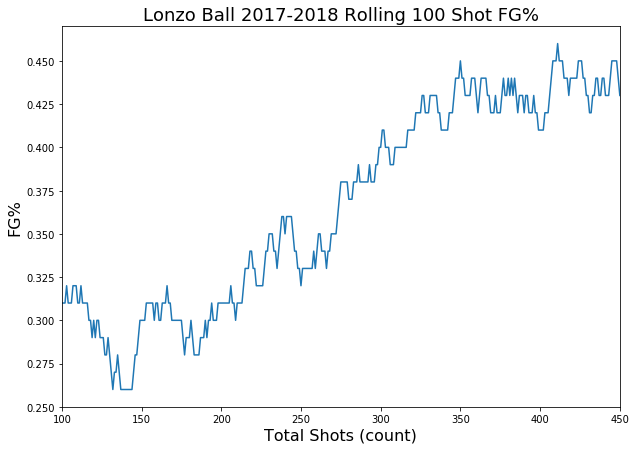

In [22]:
#First add the num_makes list to the shots dataframe for convenience
shots['num_makes'] = num_makes

roll_fg_perct = []
num_shots = []
for i in range(len(shots)-100):
    num_shots.append(i+100)
    fgs = shots['num_makes'][i:i+100]
    roll_fg_perct.append(np.mean(fgs))

fig, ax = plt.subplots(figsize=(10,7))
sns.tsplot(roll_fg_perct,num_shots)
plt.title('Lonzo Ball 2017-2018 Rolling 100 Shot FG%',fontsize=18)
plt.xlabel('Total Shots (count)',fontsize=16)
plt.ylabel('FG%',fontsize=16)

## IV. Matchup Comparison

One final thing I wanted to look at was how Lonzo has shot against different teams in the league. One easy way to do this is to simply plot his FG% against each opponent he's faced:

Text(0.5,1,'Lonzo Ball 2017-2018 FG% by Opponent')

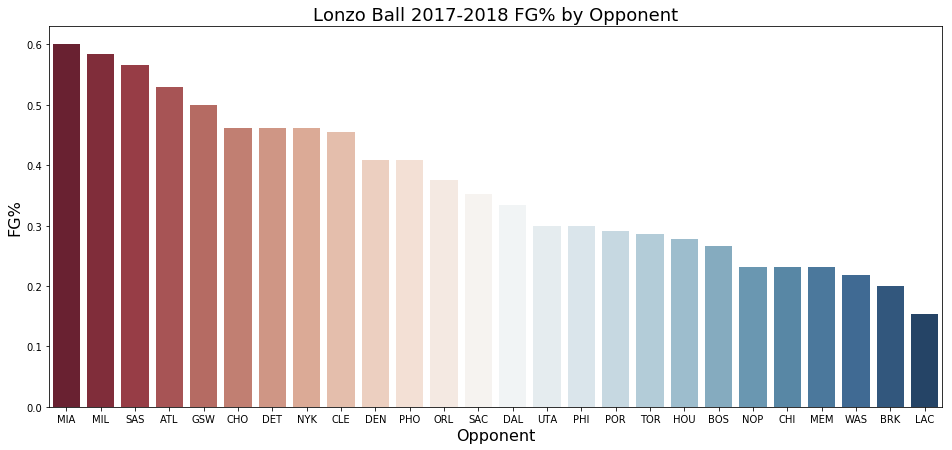

In [23]:
matchups = shots.groupby('opp')['num_makes'].mean().to_frame()
matchups = matchups.sort_values(ascending=False,by='num_makes')

fig, ax = plt.subplots(figsize=(16,7))
sns.set_style("whitegrid")

sns.barplot(x=matchups.index,y=matchups['num_makes'],saturation=0.6,
                   palette=sns.color_palette("RdBu", n_colors=26))
plt.xlabel('Opponent',fontsize=16)
plt.ylabel('FG%',fontsize=16)
plt.title('Lonzo Ball 2017-2018 FG% by Opponent',fontsize=18)

## V. Conclusion

I hope this notebook has given you a sample of some of the data science skills I could bring to this franchise. Obviously this is some rather shallow analysis, only took a couple hours, but I wanted to have something prepared quickly since you were already reviewing applications.

Thank you for your consideration and, as always, *GO LAKERS!* 